# Part 0: Import Libraries.

In [1]:
!pip install group-lasso --quiet

In [2]:
from sklearn.datasets import fetch_openml
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from group_lasso import GroupLasso
from sklearn.metrics import accuracy_score
from group_lasso import LogisticGroupLasso
from sklearn.metrics import accuracy_score, classification_report

# Part 1: Import & Process Data.

Run necessary code from notebook 1.

In [3]:
# Load Dataset
mnist = fetch_openml("mnist_784")

# Filter and Prepare Dataset
keys = list(mnist.keys())
df = pd.concat([mnist[keys[0]],mnist[keys[1]]],axis=1)
df['class'] = df['class'].apply(lambda x: int(x))
bool_musk = df['class'].isin([3,5,8])
df = df.loc[bool_musk].reset_index(drop=True)

# Split data into training and testing
cutoff = int(df.shape[0]*(0.8))
X, y = df.iloc[:,:-1], df['class']
X_train, X_test = X[:cutoff], X[cutoff:]
y_train, y_test = y[:cutoff], y[cutoff:]

# Randomize the split
n = X_train.shape[0]
rand = np.random.permutation(n)
X_train = X_train.iloc[list(rand),:].reset_index(drop = True)
y_train = y_train[rand].reset_index(drop = True)

assert X_train.shape[0] + X_test.shape[0] == df.shape[0], 'ERROR'
assert X_train.shape[1] == X_test.shape[1] == df.shape[1] - 1, 'ERROR' #class column == y
assert y_train.shape[0] + y_test.shape[0] == df.shape[0], 'ERROR'

# Formats
print(f'X_train: {X_train.shape},\nX_test: {X_test.shape},\ny_train: {y_train.shape},\ny_test: {y_test.shape}')

X_train: (16223, 784),
X_test: (4056, 784),
y_train: (16223,),
y_test: (4056,)


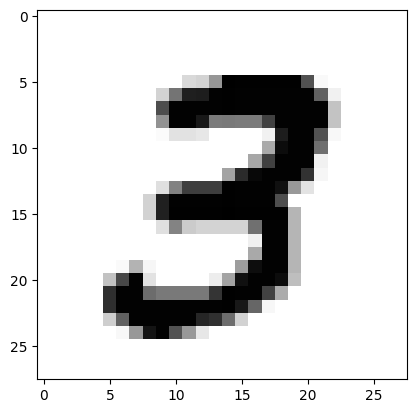


*** Image is classified as a 3 ***


In [31]:
df = pd.concat([mnist[keys[0]],mnist[keys[1]]],axis=1)
i = 7 #select any row; i = 0 -> row 0
obs = df.iloc[i,:-1].to_numpy()
obs_image = obs.astype(np.uint8).reshape(28, 28)
plt.imshow(obs_image, plt.cm.binary)
plt.show()
print(f'\n*** Image is classified as a {df.loc[i,"class"]} ***')

We will perform group LASSO on a multinomial regression in order to determin which of these pixel features are significant in identifying if the digit is 3, 5, or 8.  Intuitively it would make sense if the corners were not relevant for classifying the image, etc.  We will see the results of this process below.

# Part 2: Fit Group LASSO on Multinomial Regression

Here we perform a Multinomial Regression Group LASSO for groups. First we need to scale the data.

In [4]:
# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## 1x1 Chunk Grouping

Now initialize the model with #groups and l1 regularization.  Here we use the number of groups = number of features. This is done in order to determine the relevant features (or pixels) that are used across all digits 3, 5, and 8.  If we fit a regular LASSO, the features for each digit that shrink to 0 would differ across classes.  Now with group LASSO the features that shrink to 0 must do so across all classes which is a desirable feature.  Note, we could also use different groups such as 2x2 pixels which would likely increase accuracy; but I value interpretability and simplicity more in this fit so I just keep it simple and fit each feature (or pixel) as its own group.

In [5]:
print(f'# of groups = {X_train_scaled.shape[1]}')

# of groups = 784


In [6]:
# Initialize and train the model
model = LogisticGroupLasso(groups=np.arange(X_train_scaled.shape[1]),
                           group_reg=0.05,  # Group regularization strength
                           l1_reg=0.01,     # L1 regularization within groups
                           n_iter=1000,
                           tol=1e-4,
                           supress_warning=True
)

Fit the model and calculate the accuracy (this takes 8 minutes to run; I will make more groups to improve the computational costs in the next part).

In [7]:
model.fit(X_train_scaled, y_train) # Fit the model using scaled data
y_pred = model.predict(X_test_scaled)
y_prob = model.predict_proba(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print("Classification Report:")
print(report)

Accuracy: 0.8084
Classification Report:
              precision    recall  f1-score   support

           3       0.77      0.87      0.82      1426
           5       0.80      0.76      0.78      1257
           8       0.86      0.79      0.82      1373

    accuracy                           0.81      4056
   macro avg       0.81      0.81      0.81      4056
weighted avg       0.81      0.81      0.81      4056



Visualize the results of the group LASSO.

In [8]:
coefficients = model.coef_ # Get the coefficients to see which groups were selected
coef_df = pd.DataFrame(coefficients)
coef_df.index = X_train.columns
coef_df['sum'] = coef_df[0] + coef_df[1] + coef_df[2]
bool_musk = coef_df['sum'] != 0
nonzero_coef_df = coef_df.loc[bool_musk] #non-zero features
relevant_features = list(nonzero_coef_df.index)
print(f'There are {len(relevant_features)} nonzero features after applying group LASSO.')
print('These are the pixels group LASSO found to be significant in classification of the digit to either 3, 5, or 8.')
print(f'\nPixel List = {relevant_features}')

There are 23 nonzero features after applying group LASSO.
These are the pixels group LASSO found to be significant in classification of the digit to either 3, 5, or 8.

Pixel List = ['pixel151', 'pixel152', 'pixel153', 'pixel177', 'pixel220', 'pixel291', 'pixel292', 'pixel297', 'pixel318', 'pixel319', 'pixel325', 'pixel327', 'pixel353', 'pixel380', 'pixel381', 'pixel408', 'pixel435', 'pixel462', 'pixel487', 'pixel488', 'pixel489', 'pixel515', 'pixel516']


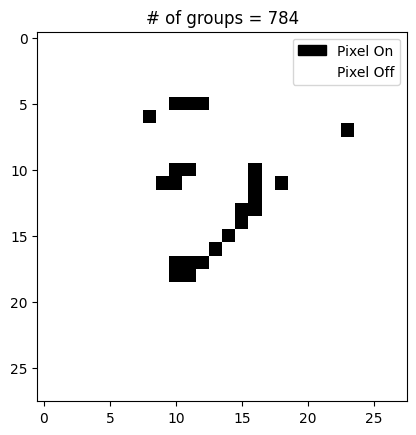

In [9]:
coef_df['binary'] = coef_df['sum'].apply(lambda x: 0 if x == 0 else 1)
image_matrix = coef_df['binary'].values.reshape((28, 28))
plt.imshow(image_matrix, cmap='binary')
plt.title(f'# of groups = {X_train_scaled.shape[1]}')

black_patch = mpatches.Patch(color='black', label='Pixel On')
white_patch = mpatches.Patch(color='white', label='Pixel Off')
plt.legend(handles=[black_patch, white_patch], loc='upper right') # Add legend

plt.show()

## Define Functions (Testing Groups)

In [10]:
def fit_summary(groups):
    # Initialize and train the model
  model = LogisticGroupLasso(groups=groups,
                            group_reg=0.05,  # Group regularization strength
                            l1_reg=0.01,     # L1 regularization within groups
                            n_iter=1000,
                            tol=1e-4,
                            supress_warning=True
  )
  model.fit(X_train_scaled, y_train) # Fit the model using scaled data
  y_pred = model.predict(X_test_scaled)
  y_prob = model.predict_proba(X_test_scaled)
  accuracy = accuracy_score(y_test, y_pred)
  report = classification_report(y_test, y_pred)

  print(f"Accuracy: {accuracy:.4f}")
  print("Classification Report:")
  print(report)

  coefficients = model.coef_ # Get the coefficients to see which groups were selected
  coef_df = pd.DataFrame(coefficients)
  coef_df.index = X_train.columns
  coef_df['sum'] = coef_df[0] + coef_df[1] + coef_df[2]
  bool_musk = coef_df['sum'] != 0
  nonzero_coef_df = coef_df.loc[bool_musk] #non-zero features
  relevant_features = list(nonzero_coef_df.index)
  print(f'There are {len(relevant_features)} nonzero features after applying group LASSO.')
  print('These are the pixels group LASSO found to be significant in classification of the digit to either 3, 5, or 8.')
  print(f'\nPixel List = {relevant_features}')
  coef_df['binary'] = coef_df['sum'].apply(lambda x: 0 if x == 0 else 1)
  image_matrix = coef_df['binary'].values.reshape((28, 28))
  plt.imshow(image_matrix, cmap='binary')
  plt.title(f'# of groups = {len(np.unique(groups))}')

  black_patch = mpatches.Patch(color='black', label='Pixel On')
  white_patch = mpatches.Patch(color='white', label='Pixel Off')
  plt.legend(handles=[black_patch, white_patch], loc='upper right') # Add legend

  plt.show()

Now we try to improve the results by using fewer groups:

- Encourages more aggressive feature selection (more features dropped together).
- Can improve interpretability by selecting entire feature sets.
- Helps when features within a group are highly correlated.

## 2x1 Chunk Grouping

In [14]:
# Create a 28x28 matrix with paired numbers that continue across rows
rows = 28
cols = 28
pairs_per_row = cols // 2  # How many pairs in each row

# Initialize the matrix
groups = np.zeros((rows, cols), dtype=int)

# Fill the matrix with pairs of continuing numbers
for i in range(rows):
    row_numbers = []
    start_number = i * pairs_per_row + 1
    for j in range(pairs_per_row):
        current_number = start_number + j
        row_numbers.extend([current_number, current_number])
    groups[i] = row_numbers


The groups can be visualized by 1x2 chunks in a 28x28 image.  As given below:

In [15]:
# Print the matrix with proper alignment
for row in groups:
    formatted_row = []
    for num in row:
        # Format each individual number, not the entire array
        formatted_row.append(f"{num:3d}")
    print("[" + " ".join(formatted_row) + "]")

[  1   1   2   2   3   3   4   4   5   5   6   6   7   7   8   8   9   9  10  10  11  11  12  12  13  13  14  14]
[ 15  15  16  16  17  17  18  18  19  19  20  20  21  21  22  22  23  23  24  24  25  25  26  26  27  27  28  28]
[ 29  29  30  30  31  31  32  32  33  33  34  34  35  35  36  36  37  37  38  38  39  39  40  40  41  41  42  42]
[ 43  43  44  44  45  45  46  46  47  47  48  48  49  49  50  50  51  51  52  52  53  53  54  54  55  55  56  56]
[ 57  57  58  58  59  59  60  60  61  61  62  62  63  63  64  64  65  65  66  66  67  67  68  68  69  69  70  70]
[ 71  71  72  72  73  73  74  74  75  75  76  76  77  77  78  78  79  79  80  80  81  81  82  82  83  83  84  84]
[ 85  85  86  86  87  87  88  88  89  89  90  90  91  91  92  92  93  93  94  94  95  95  96  96  97  97  98  98]
[ 99  99 100 100 101 101 102 102 103 103 104 104 105 105 106 106 107 107 108 108 109 109 110 110 111 111 112 112]
[113 113 114 114 115 115 116 116 117 117 118 118 119 119 120 120 121 121 122 122 123 123

Reshape into array to feed it into the model.

In [16]:
groups = groups.reshape((1,784))[0]

Now to fit Group LASSO Multinomial Regression on this group schematic!

Accuracy: 0.8151
Classification Report:
              precision    recall  f1-score   support

           3       0.78      0.88      0.83      1426
           5       0.81      0.76      0.78      1257
           8       0.86      0.81      0.83      1373

    accuracy                           0.82      4056
   macro avg       0.82      0.81      0.81      4056
weighted avg       0.82      0.82      0.81      4056

There are 38 nonzero features after applying group LASSO.
These are the pixels group LASSO found to be significant in classification of the digit to either 3, 5, or 8.

Pixel List = ['pixel151', 'pixel152', 'pixel153', 'pixel154', 'pixel177', 'pixel178', 'pixel191', 'pixel192', 'pixel219', 'pixel220', 'pixel291', 'pixel292', 'pixel297', 'pixel298', 'pixel317', 'pixel318', 'pixel319', 'pixel320', 'pixel325', 'pixel326', 'pixel327', 'pixel328', 'pixel345', 'pixel346', 'pixel351', 'pixel352', 'pixel353', 'pixel354', 'pixel407', 'pixel408', 'pixel461', 'pixel462', 'pixel487', 

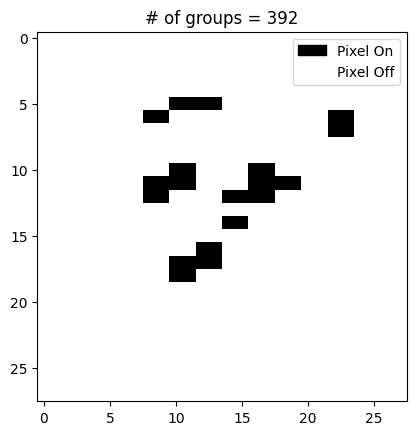

In [17]:
fit_summary(groups)

This looks a bit nicer then the single pixel grouping schema and the accuracy has improved.  I bet the accuracy would improve if we implemented 4x4 chunks of pixels as groups!  Lets try this.

## 2x2 Chunk Grouping

In [18]:
# Create a 28x28 matrix filled with zeros
groups = np.zeros((28, 28))

# Calculate how many 2x2 chunks we'll have in total
chunks_per_row = 28 // 2
chunks_per_col = 28 // 2
total_chunks = chunks_per_row * chunks_per_col  # This should equal 196 (28×28/4)


counter = 1 # Fill the matrix with 2x2 chunks counting up from 1
for i in range(0, 28, 2):
    for j in range(0, 28, 2):
        groups[i:i+2, j:j+2] = counter
        counter += 1

In [19]:
groups

array([[  1.,   1.,   2.,   2.,   3.,   3.,   4.,   4.,   5.,   5.,   6.,   6.,   7.,   7.,   8.,   8.,   9.,   9.,  10.,  10.,  11.,  11.,  12.,  12.,  13.,  13.,  14.,  14.],
       [  1.,   1.,   2.,   2.,   3.,   3.,   4.,   4.,   5.,   5.,   6.,   6.,   7.,   7.,   8.,   8.,   9.,   9.,  10.,  10.,  11.,  11.,  12.,  12.,  13.,  13.,  14.,  14.],
       [ 15.,  15.,  16.,  16.,  17.,  17.,  18.,  18.,  19.,  19.,  20.,  20.,  21.,  21.,  22.,  22.,  23.,  23.,  24.,  24.,  25.,  25.,  26.,  26.,  27.,  27.,  28.,  28.],
       [ 15.,  15.,  16.,  16.,  17.,  17.,  18.,  18.,  19.,  19.,  20.,  20.,  21.,  21.,  22.,  22.,  23.,  23.,  24.,  24.,  25.,  25.,  26.,  26.,  27.,  27.,  28.,  28.],
       [ 29.,  29.,  30.,  30.,  31.,  31.,  32.,  32.,  33.,  33.,  34.,  34.,  35.,  35.,  36.,  36.,  37.,  37.,  38.,  38.,  39.,  39.,  40.,  40.,  41.,  41.,  42.,  42.],
       [ 29.,  29.,  30.,  30.,  31.,  31.,  32.,  32.,  33.,  33.,  34.,  34.,  35.,  35.,  36.,  36.,  37.,  37.,

Now let us verify if this grouping method improves the accuracy.

In [20]:
groups = groups.reshape((1,784))[0]

# Initialize and train the model
model = LogisticGroupLasso(groups=groups,
                           group_reg=0.05,  # Group regularization strength
                           l1_reg=0.01,     # L1 regularization within groups
                           n_iter=1000,
                           tol=1e-4,
                           supress_warning=True
)

Accuracy: 0.8074
Classification Report:
              precision    recall  f1-score   support

           3       0.77      0.87      0.82      1426
           5       0.82      0.74      0.78      1257
           8       0.84      0.81      0.82      1373

    accuracy                           0.81      4056
   macro avg       0.81      0.80      0.81      4056
weighted avg       0.81      0.81      0.81      4056

There are 44 nonzero features after applying group LASSO.
These are the pixels group LASSO found to be significant in classification of the digit to either 3, 5, or 8.

Pixel List = ['pixel123', 'pixel124', 'pixel151', 'pixel152', 'pixel191', 'pixel192', 'pixel219', 'pixel220', 'pixel291', 'pixel292', 'pixel297', 'pixel298', 'pixel319', 'pixel320', 'pixel325', 'pixel326', 'pixel345', 'pixel346', 'pixel351', 'pixel352', 'pixel353', 'pixel354', 'pixel373', 'pixel374', 'pixel379', 'pixel380', 'pixel381', 'pixel382', 'pixel407', 'pixel408', 'pixel435', 'pixel436', 'pixel459', 

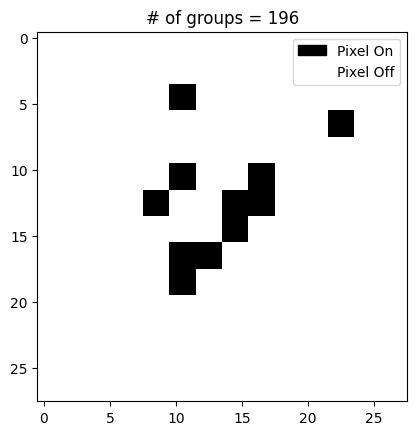

In [21]:
fit_summary(groups)

Looks good.  I think all of these methods are acceptable.  Hyperparameter tuning can be done to optimize the parameters group_regularization and l1_regularization (as well as group selection like what we have done here on a naive level).

*End of Notebook 2*